In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Loading data...")
data = np.load('data.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Data preprocessing
def preprocess_images(images):
    # Flatten and normalize the images
    processed_images = images.reshape(-1, 28*28).astype(np.float32) / 255.0
    return processed_images

# Create validation split
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Preprocess the data
X_train_processed = preprocess_images(X_train_split)
X_val_processed = preprocess_images(X_val)
X_test_processed = preprocess_images(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_processed)
y_train_tensor = torch.from_numpy(y_train_split).long()
X_val_tensor = torch.from_numpy(X_val_processed)
y_val_tensor = torch.from_numpy(y_val).long()
X_test_tensor = torch.from_numpy(X_test_processed)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# MLP model with two hidden layers
class ImprovedNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(ImprovedNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], output_size)
        )

    def forward(self, x):
        return self.model(x)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model
input_size = 28*28  # Flattened 28x28 images
hidden_sizes = [384, 192]  # Two hidden layers
output_size = 15    # 15 class labels
model = ImprovedNN(input_size, hidden_sizes, output_size).to(device)
print(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler to improve training
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# Training
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

#validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Training loop
num_epochs = 50  # number of epochs
best_val_acc = 0.0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update learning rate scheduler
    scheduler.step(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_hexagonia_mlp_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Loads the best model from the epochs
model.load_state_dict(torch.load('best_hexagonia_mlp_model.pth'))

# validation accuracy check using the best model
_, final_val_acc = validate(model, val_loader, criterion, device)
print(f"Final validation accuracy: {final_val_acc:.2f}%")

# Generate predictions for the test set
model.eval()
all_preds = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor), batch_size):
        batch = X_test_tensor[i:i+batch_size].to(device)
        outputs = model(batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

# Create kaggle submission file
submission = pd.DataFrame({
    'ID': range(len(all_preds)),
    'Label': all_preds
})
submission.to_csv('hexagonia_submission.csv', index=False)
print("Submission file created: hexagonia_submission.csv")

# Print best validation accuracy achieved during training (same as sbove)
# print(f"Best validation accuracy: {best_val_acc:.2f}%")

Loading data...
Training data shape: (82875, 784)
Training labels shape: (82875,)
Test data shape: (14625, 784)
Using device: cpu
ImprovedNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=384, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=384, out_features=192, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=192, out_features=15, bias=True)
  )
)
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss: 1.0275, Train Acc: 66.20%, Val Loss: 0.6784, Val Acc: 77.53%
Epoch 2/50: Train Loss: 0.6876, Train Acc: 77.33%, Val Loss: 0.5512, Val Acc: 81.52%
Epoch 3/50: Train Loss: 0.5733, Train Acc: 80.97%, Val Loss: 0.4905, Val Acc: 83.36%
Epoch 4/50: Train Loss: 0.5090, Train Acc: 83.19%, Val Loss: 0.4333, Val Acc: 85.42%
Epoch 5/50: Train Loss: 0.4645, Train Acc: 84.40%, Val Loss: 0.4194, Val Acc: 85.65%
Epoch 6/50: Train Loss: 0.4386, Train Acc: 85.25%, Val Loss: 0.3828, Val Acc: 86.94%
Epoch 7/50: Train Loss: 0.4044, Train Acc: 86.38%, Val Loss: 0.3693, Val Acc: 87.44%
Epoch 8/50: Train Loss: 0.3807, Train Acc: 87.09%, Val Loss: 0.3621, Val Acc: 87.61%
Epoch 9/50: Train Loss: 0.3617, Train Acc: 87.78%, Val Loss: 0.3531, Val Acc: 87.96%
Epoch 10/50: Train Loss: 0.3496, Train Acc: 88.14%, Val Loss: 0.3325, Val Acc: 88.58%
Epoch 11/50: Train Loss: 0.3327, Train Acc: 88.66%, Val Loss: 0.3373, Val Acc: 88.77%
Epoch 12/50: Train Loss: 0.3255, Train Acc: 88.87%, Val Loss: 0

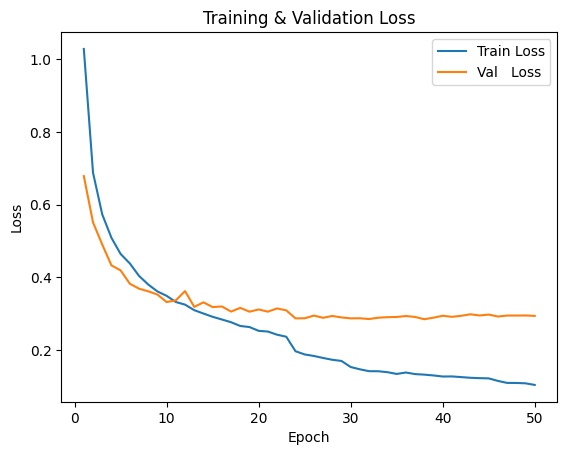

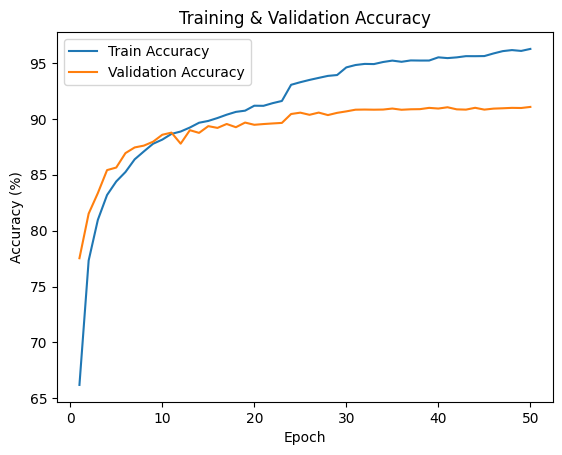

In [4]:
import matplotlib.pyplot as plt

# 1) Prepare epoch indices
epochs = range(1, len(train_losses) + 1)

# 2) Plot Loss curves
plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val   Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# 3) Plot Accuracy curves
plt.figure()
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs,   label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()
